The purpose of this file is to inspect the HSQC to see if the positional encoding is working properly

Updated 03/07/23 for GenericIndexedModule

In [2]:
from datasets.generic_index_dataset import GenericIndexedModule
from datasets.dataset_utils import pad
from models.identity_module import IdentityModule
from pathlib import Path
import os, pytorch_lightning as pl
import torch

### Dataset Statistics

In [3]:
direct = Path("tempdata/SMILES_dataset")
features = ["HSQC", "HYUN_FP"]
feature_handlers = [pad, None]
gim = GenericIndexedModule(direct, features, feature_handlers, len_override = 5)
gim.setup("fit")
model = IdentityModule()
tr_dl = gim.train_dataloader()
val_dl = gim.val_dataloader()

In [4]:
maxs = torch.tensor([-torch.inf, -torch.inf, -torch.inf])
mins = torch.tensor([torch.inf, torch.inf, torch.inf])
for batch in tr_dl:
  hsqc, _ = batch
  batch_max = torch.amax(hsqc, dim=(0, 1))
  batch_min = torch.amin(hsqc, dim=(0, 1))
  maxs = torch.maximum(maxs, batch_max)
  mins = torch.minimum(mins, batch_min)
print(f"Global Maximum")
for v in maxs.flatten():
  print(f"   {v.item()}")
print(f"Global Minimums: {mins}")
for v in mins.flatten():
  print(f"   {v.item()}")

Global Maximum
   147.1699981689453
   8.652000427246094
   15757.1318359375
Global Minimums: tensor([    0.0000,     0.0000, -9319.5547])
   0.0
   0.0
   -9319.5546875


### Visualize Encoding

In [5]:
for batch in tr_dl:
  hsqc, fp = batch
  break

In [6]:
import encoder as p

hsqc, fp = hsqc.cuda(), fp.cuda()
print(hsqc.size(), fp.size())
division = (60, 60, 8)
ce = p.SignCoordinateEncoder(128, division, wavelength_bounds=[(0.01, 140), (0.01, 9)]).cuda()
res = ce(hsqc)
print(res.size())

Pushed an encoder with bounds 0.01, 140
Sin wavelengths: tensor([3.9478e+03, 2.8405e+03, 2.0437e+03, 1.4704e+03, 1.0580e+03, 7.6122e+02,
        5.4770e+02, 3.9407e+02, 2.8353e+02, 2.0400e+02, 1.4678e+02, 1.0561e+02,
        7.5984e+01, 5.4670e+01, 3.9335e+01, 2.8302e+01, 2.0363e+01, 1.4651e+01,
        1.0541e+01, 7.5850e+00, 5.4570e+00, 3.9260e+00, 2.8250e+00, 2.0330e+00,
        1.4620e+00, 1.0520e+00, 7.5700e-01, 5.4500e-01, 3.9200e-01, 2.8200e-01])
Cos wavelengths: tensor([3.9478e+03, 2.8405e+03, 2.0437e+03, 1.4704e+03, 1.0580e+03, 7.6122e+02,
        5.4770e+02, 3.9407e+02, 2.8353e+02, 2.0400e+02, 1.4678e+02, 1.0561e+02,
        7.5984e+01, 5.4670e+01, 3.9335e+01, 2.8302e+01, 2.0363e+01, 1.4651e+01,
        1.0541e+01, 7.5850e+00, 5.4570e+00, 3.9260e+00, 2.8250e+00, 2.0330e+00,
        1.4620e+00, 1.0520e+00, 7.5700e-01, 5.4500e-01, 3.9200e-01, 2.8200e-01])
Pushed an encoder with bounds 0.01, 9
Sin wavelengths: tensor([3947.8420, 3122.4060, 2469.5559, 1953.2080, 1544.8199, 1221.8

torch.Size([5, 21, 3]) torch.Size([5, 6144])
torch.Size([5, 21, 128])


54.8900, 3.0770, -1.0000
54.8900, 3.4800, -1.0000
37.0500, 2.7100, 1.0000
26.9500, 2.0800, 1.0000
24.2400, 2.2300, -1.0000
24.2400, 1.8800, -1.0000
44.3500, 4.5400, -1.0000
44.3500, 3.1880, -1.0000
18.3700, 2.1200, -1.0000
18.3700, 1.2930, -1.0000
60.1800, 3.3410, 1.0000
66.0500, 5.9200, 1.0000
137.1800, 5.5300, 1.0000
117.2900, 5.0100, -1.0000
117.2900, 5.0000, -1.0000
146.8700, 8.6520, 1.0000
118.9300, 7.6610, 1.0000
99.8900, 6.9530, 1.0000
122.4300, 7.0260, 1.0000
131.1900, 7.7290, 1.0000
57.5800, 3.6970, 1.0000


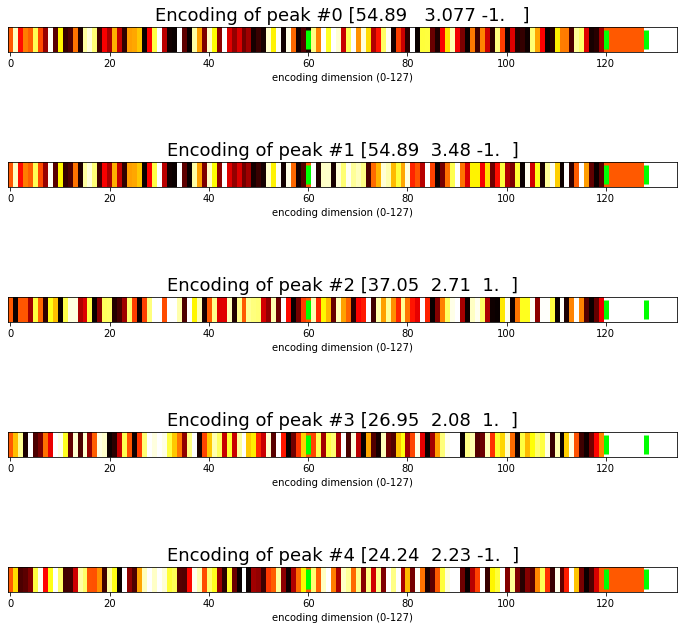

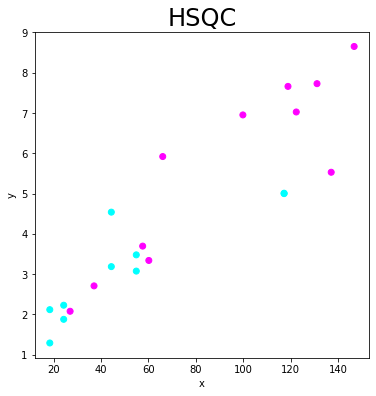

In [25]:
import matplotlib.pyplot as plt
import numpy as np
def show_encoding(encoding, hsqc, title = None):
  if title:
    plt.title(title)
  plt.figure(figsize=(12,12))
  for row in range(5):
    plt.subplot(5, 1, row + 1)
    plt.title(f"Encoding of peak #{row} {np.round(hsqc[row].cpu().numpy(), 4)}", fontsize=18)
    single_row = encoding.cpu()[[row],:]
    plt.xlabel(f"encoding dimension (0-{single_row.size()[1] - 1})")
    repeated = torch.repeat_interleave(single_row, 5, dim = 0)
    plt.imshow(repeated, cmap='hot')
    plt.vlines([sum(division[:j+1]) for j in range(len(division))], 0, 4, colors="lime", linewidth=5)
    plt.tick_params(
      axis='y',
      which='both',
      left=False,
      labelleft=False
    )
  plt.show()
def show_hsqc(hsqc):
  hsqc = hsqc.cpu()
  plt.figure(figsize=(6, 6))
  plt.title("HSQC", fontsize=24)
  plt.xlabel("x")
  plt.ylabel("y")
  plt.scatter(hsqc[:,0], hsqc[:,1], c=hsqc[:,2], cmap="cool")
for row in hsqc[0]:
  row_li = row.tolist()
  print(f"{row_li[0]:>.4f}, {row_li[1]:>.4f}, {row_li[2]:>.4f}")
show_encoding(res[0], hsqc[0], "")
show_hsqc(hsqc[0])